# Assignment 03

In [1]:
%matplotlib inline

In [2]:
from Data import Data
from NBC import Model, average_accuracy
from Vocabulary import Vocabulary
import pandas as pd
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Reading the vocabulary file included with the data folder.
<br>
See [Vocabulary.py](Vocabulary.py)

In [3]:
vocab = Vocabulary(r'aclImdb\\imdb.vocab')

In [4]:
print(f'Stopwords: {vocab.stopwords}')

Stopwords: {'because', 'haven', 'than', 'll', 'needn', 'in', 'her', 'into', 'hers', "doesn't", "you're", 'off', 'wouldn', 'were', 'ours', 'wasn', 'here', "don't", 'as', 'where', "should've", 'then', 'our', 'himself', 'no', 'through', 'just', 'having', 'up', 'each', 'd', 'i', 'don', 'should', 'does', 'so', "you've", 'o', 'had', 'own', 'that', "won't", "shan't", 'more', "wasn't", 'from', 'didn', 'down', 'to', 'out', 'while', "mightn't", 'hadn', 'other', 'is', 'been', 'most', 'did', 'yours', 'yourself', 'm', 'now', 'doing', "shouldn't", 'isn', 'after', 'ain', 'shouldn', 'any', 'again', 'theirs', 'itself', 'a', 'be', 'ma', 'are', 'has', 'few', 'me', 'same', 've', 'against', 'too', 'my', 'which', 'or', 'it', 'only', "didn't", 'but', 'ourselves', "that'll", 'during', 'how', 'not', 'whom', 'yourselves', "hadn't", 'who', 'at', 'some', 'for', 's', 'this', 'he', 'by', 'about', 'both', 'do', 't', 'before', 'above', 'once', 'when', 'will', "isn't", 'if', 'mightn', 'all', 'have', 'with', 'herself',

Reading the [train](aclImdb/train/labeledBow.feat) reviews file using 5 fold cross-validation.

See [Data.py](Data.py) and [Reviews.py](Reviews.py)

In [5]:
k = 5
data_sets = list(Data.read_train('aclImdb', k))

Creating NBC models for each of the data set that was produced by 5 fold cross-validation.
<br>
See [NBC.py](NBC.py)

In [6]:
models = [Model(x.train, vocab) for x in data_sets]

In [7]:
reviews = data_sets[0].all_train
index_the = vocab.get_index('the')

Calculating $P[“the”]$ = num of documents containing ‘the’ / num of all documents

In [8]:
print(f'P["the"] = {reviews.count(index_the) / len(reviews.all)}')

P["the"] = 0.99168


Calculating $P[“the” | Positive]$ = # of positive documents containing “the” / num of all positive review documents

In [9]:
print(f'P["the" | Positive] = {reviews.count_positive(index_the) / len(reviews.positive)}')

P["the" | Positive] = 0.99048


Calculating the average accuracy of these models without any smoothing and ignoring stop words only.

In [10]:
dev_data = [x.dev for x in data_sets]
accuracy = average_accuracy(models, dev_data, smoothen=0, min_occurrence=0)
print(f'Average accuracy = {accuracy:.4%}')

Average accuracy = 74.7840%


Calculating the accuracy using smoothing hyperparameters in the range $[0, 1]$ with step size $0.1$

In [11]:
h_params = {}
for i in (x * 0.1 for x in range(0, 11)):
    h_params[i] = average_accuracy(models, dev_data, i, 0)
smoothing_accuracies = pd.DataFrame.from_dict(h_params, orient='index', columns=['Accuracy'])

In [12]:
smoothing_accuracies

,Accuracy
0.0,0.74784
0.1,0.85432
0.2,0.85744
0.3,0.85884
0.4,0.85856
0.5,0.85940
0.6,0.85960
0.7,0.85988
0.8,0.86004
0.9,0.85980


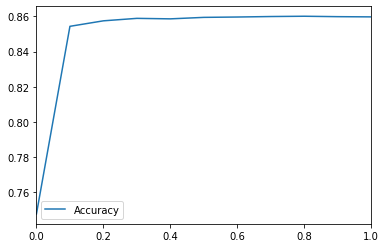

In [13]:
smoothing_accuracies.plot()

It's worth noting that increase the smoothing parameter from `0` even in the slightest increases accuracy considerably.
<br>
This is because a lot of the words were forcing the probability calculation to be `0`
<br>
rendering any other words in the same review useless.

In [14]:
h_params = {}
for i in (x * 0.00025 for x in range(0, 11)):
    h_params[i] = average_accuracy(models, dev_data, 0, i)
min_occurrence_accuracies = pd.DataFrame.from_dict(h_params, orient='index', columns=['Accuracy'])

In [15]:
min_occurrence_accuracies

,Accuracy
0.00000,0.74784
0.00025,0.83300
0.00050,0.85224
0.00075,0.85412
0.00100,0.85448
0.00125,0.85476
0.00150,0.85332
0.00175,0.85352
0.00200,0.85348
0.00225,0.85192


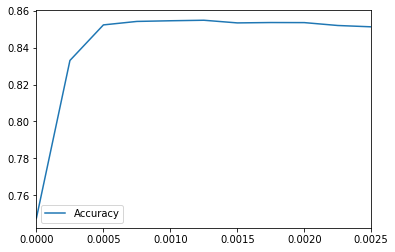

In [16]:
min_occurrence_accuracies.plot()

The accuracy improves significantly if we ignore words that occur rarely, 
<br>
specially those that occur $0$ times in either `Positive` or `Negative` class.
<br>
The above plot is for varying values of `min_occurences` with `smoothen=0`.

Redrawing the same plot with `smoothen=1`.

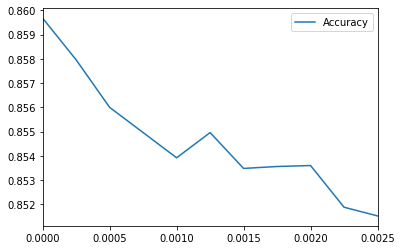

In [17]:
h_params = {}
for i in (x * 0.00025 for x in range(0, 11)):
    h_params[i] = average_accuracy(models, dev_data, 1, i)
min_occurrence_accuracies = pd.DataFrame.from_dict(h_params, orient='index', columns=['Accuracy'])
min_occurrence_accuracies.plot()

The accuracy is now decereasing but the absolute change in accuracy is rather small in comparison to before.
<br>
Simply maximizing both the hyperparameters does not yield better results.
<br>
The ideal model is a balance between the 2 hyperparameters which is rather expensive to compute in this example.

For the final accuracy calculation, `smoothen=1` and `min_occurrence=0.00025` is used.
<br>
[train](aclImdb/train/labeledBow.feat) and [test](aclImdb/test/labeledBow.feat) reviews are combined and used in 5 fold cross-validation for the final models.

In [18]:
data_sets = list(Data.read_all('aclImdb', k))

In [19]:
models = [Model(x.train, vocab) for x in data_sets]

In [20]:
test_data = [x.test for x in data_sets]
accuracy = average_accuracy(models, test_data, smoothen=1, min_occurrence=0.00025)
print(f'Average accuracy = {accuracy:.4%}')

Average accuracy = 85.7680%


In [21]:
pos_words, neg_words = models[0].top_words(top_count=10, min_occurrence=0)
print(f'Top 10 positive predicting words:\n{pos_words}')
print()
print(f'Top 10 negative predicting words:\n{neg_words}')

Top 10 positive predicting words:
['gundam', 'gunga', 'gypo', 'yokai', 'creasy', 'gackt', 'blandings', 'kells', 'gino', 'brashear']

Top 10 negative predicting words:
['sarne', 'gram', 'mraovich', 'domergue', 'toolbox', 'slaughterhouse', 'sade', 'hamiltons', 'triton', 'advani']


The top words seem like typos or otherwise meaningless because 
<br>
these words occured just once in their prediction class and never occured again.

In [22]:
pos_words, neg_words = models[0].top_words(top_count=10, min_occurrence=0.01)
print(f'Top 10 positive predicting words:\n{pos_words}')
print()
print(f'Top 10 negative predicting words:\n{neg_words}')

Top 10 positive predicting words:
['wonderfully', 'beautifully', 'superb', 'outstanding', 'gem', 'finest', 'touching', 'excellent', 'magnificent', 'terrific']

Top 10 negative predicting words:
['waste', 'worst', 'laughable', 'awful', 'redeeming', 'poorly', 'pointless', 'sucks', 'lame', 'whatsoever']


The top words now seem meaningful after filtering out words that occur too rarely (in less than $1\%$ of the reviews).